# 9.2. 长短期记忆网络（LSTM）
长期以来，隐变量模型存在着长期信息保存和短期输入缺失的问题。解决这一问题的最早方法之一是长短期存储器（long short-term memory，LSTM）。它有许多与门控循环单元（[9.1节](./L9_1_门控循环单元(GRU).ipynb)）一样的属性。有趣的是，长短期记忆网络的设计比门控循环单元稍微复杂一些，却比门控循环单元早诞生了近20年。

## 9.2.1. 门控记忆元
可以说，长短期记忆网络的设计灵感来自于计算机的逻辑门。长短期记忆网络引入了**记忆元**（memory cell），或简称为**单元**（cell）。有些文献认为记忆元是隐状态的一种特殊类型，它们与隐状态具有相同的形状，其设计目的是用于记录附加的信息。

为了控制记忆元，我们需要许多门。其中一个门用来从单元中输出条目，我们将其称为**输出门**（output gate）。另外一个门用来决定何时将数据读入单元，我们将其称为**输入门**（input gate）。我们还需要一种机制来重置单元的内容，由**遗忘门**（forget gate）来管理，这种设计的动机与门控循环单元相同，能够通过专用机制决定什么时候记忆或忽略隐状态中的输入。

让我们看看这在实践中是如何运作的。

### 输入门、忘记门和输出门

- 忘记门：将值朝0减少
- 输入门：决定不是忽略掉输入数据
- 输出门：决定是不是使用隐状态

就如在门控循环单元中一样，当前时间步的输入和前一个时间步的隐状态作为数据送入长短期记忆网络的门中，如下图所示。它们由三个具有sigmoid激活函数的全连接层处理，以计算输入门、遗忘门和输出门的值。因此，这三个门的值都在$(0, 1)$的范围内。

![](../img/9_4.png)

我们来细化一下长短期记忆网络的数学表达。假设有$h$个隐藏单元，批量大小为$n$，输入数为$d$。因此，输入为$\mathbf{X}_t \in \mathbb{R}^{n \times d}$，前一时间步的隐状态为$\mathbf{H}_{t-1} \in \mathbb{R}^{n \times h}$。相应地，时间步$t$的门被定义如下：输入门是$\mathbf{I}_t \in \mathbb{R}^{n \times h}$，遗忘门是$\mathbf{F}_t \in \mathbb{R}^{n \times h}$，输出门是$\mathbf{O}_t \in \mathbb{R}^{n \times h}$。它们的计算方法如下：

$$
\begin{aligned}
\mathbf{I}_t &= \sigma(\mathbf{X}_t \mathbf{W}_{xi} + \mathbf{H}_{t-1} \mathbf{W}_{hi} + \mathbf{b}_i),\\
\mathbf{F}_t &= \sigma(\mathbf{X}_t \mathbf{W}_{xf} + \mathbf{H}_{t-1} \mathbf{W}_{hf} + \mathbf{b}_f),\\
\mathbf{O}_t &= \sigma(\mathbf{X}_t \mathbf{W}_{xo} + \mathbf{H}_{t-1} \mathbf{W}_{ho} + \mathbf{b}_o),
\end{aligned} \tag{9.2.1}
$$

其中$\mathbf{W}_{xi}, \mathbf{W}_{xf}, \mathbf{W}_{xo} \in \mathbb{R}^{d \times h}$和$\mathbf{W}_{hi}, \mathbf{W}_{hf}, \mathbf{W}_{ho} \in \mathbb{R}^{h \times h}$是权重参数，$\mathbf{b}_i, \mathbf{b}_f, \mathbf{b}_o \in \mathbb{R}^{1 \times h}$是偏置参数。

### 候选记忆元
由于还没有指定各种门的操作，所以先介绍**候选记忆元**（candidate memory cell）$\tilde{\mathbf{C}}_t \in \mathbb{R}^{n \times h}$。它的计算与上面描述的三个门的计算类似，但是使用$\tanh$函数作为激活函数，函数的值范围为$(-1, 1)$。下面导出在时间步$t$处的方程：

$$\tilde{\mathbf{C}}_t = \text{tanh}(\mathbf{X}_t \mathbf{W}_{xc} + \mathbf{H}_{t-1} \mathbf{W}_{hc} + \mathbf{b}_c), \tag{9.2.2}$$

其中$\mathbf{W}_{xc} \in \mathbb{R}^{d \times h}$和$\mathbf{W}_{hc} \in \mathbb{R}^{h \times h}$是权重参数，$\mathbf{b}_c \in \mathbb{R}^{1 \times h}$是偏置参数。

候选记忆元的如下图所示。
![候选记忆元](../img/9_5.png)

### 记忆元
在门控循环单元中，有一种机制来控制输入和遗忘（或跳过）。类似地，在长短期记忆网络中，也有两个门用于这样的目的：输入门$\mathbf{I}_t$控制采用多少来自$\tilde{\mathbf{C}}_t$的新数据，而遗忘门$\mathbf{F}_t$控制保留多少过去的记忆元$\mathbf{C}_{t-1} \in \mathbb{R}^{n \times h}$的内容。使用按元素乘法，得出：

$$\mathbf{C}_t = \mathbf{F}_t \odot \mathbf{C}_{t-1} + \mathbf{I}_t \odot \tilde{\mathbf{C}}_t. \tag{9.2.3}$$

如果遗忘门始终为$1$且输入门始终为$0$，则过去的记忆元$\mathbf{C}_{t-1}$将随时间被保存并传递到当前时间步。引入这种设计是为了**缓解梯度消失问题，并更好地捕获序列中的长距离依赖关系**。这样我们就得到了计算记忆元的流程图，如下图。


![记忆元](../img/9_6.png)

### 隐状态
最后，我们需要定义如何计算隐状态$\mathbf{H}_t \in \mathbb{R}^{n \times h}$，这就是输出门发挥作用的地方。在长短期记忆网络中，它仅仅是记忆元的$\tanh$的门控版本。这就确保了$\mathbf{H}_t$的值始终在区间$(-1, 1)$内：

$$\mathbf{H}_t = \mathbf{O}_t \odot \tanh(\mathbf{C}_t).\tag{9.2.4}$$

只要输出门接近$1$，我们就能够有效地将所有记忆信息传递给预测部分，而对于输出门接近$0$，我们只保留记忆元内的所有信息，而不需要更新隐状态。下图提供了数据流的图形化演示。

![](../img/9_7.png)



![](../img/9_20.png)

## 9.2.2. 从零开始实现

In [1]:
"""
加载时光机器数据集。
"""

import torch
from torch import nn
from d2l import torch as d2l

batch_size,num_steps=32,35
train_iter,vocab=d2l.load_data_time_machine(batch_size,num_steps)

### 初始化模型参数

In [2]:
"""
接下来，我们需要定义和初始化模型参数。 如前所述，超参数num_hiddens定义隐藏单元的数量。 我们按照标准差0.01的高斯分布初始化权重，并将偏置项设为0。
"""
def get_lstm_params(vocab_size,num_hiddens,device):
    num_inputs=num_outputs=vocab_size

    def normal(shape):
        return torch.randn(size=shape,device=device)*0.01

    def three():
        return (normal((num_inputs,num_hiddens)),
                normal((num_hiddens,num_hiddens)),
                torch.zeros(num_hiddens,device=device))

    W_xi, W_hi, b_i = three()  # 输入门参数
    W_xf, W_hf, b_f = three()  # 遗忘门参数
    W_xo, W_ho, b_o = three()  # 输出门参数
    W_xc, W_hc, b_c = three()  # 候选记忆元参数

    # 输出层参数
    W_hq = normal((num_hiddens, num_outputs))
    b_q = torch.zeros(num_outputs, device=device)

    # 附加梯度
    params = [W_xi, W_hi, b_i, W_xf, W_hf, b_f, W_xo, W_ho, b_o, W_xc, W_hc,
              b_c, W_hq, b_q]
    for param in params:
        param.requires_grad_(True)
    return params


### 定义模型

In [3]:
"""
在初始化函数中， 长短期记忆网络的隐状态需要返回一个额外的记忆元， 单元的值为0，形状为（批量大小，隐藏单元数）。 因此，我们得到以下的状态初始化。
"""
def init_lstm_state(batch_size,num_hiddens,device):
    return(torch.zeros((batch_size,num_hiddens),device=device),
           torch.zeros((batch_size,num_hiddens),device=device)
           )

**实际模型**的定义与我们前面讨论的一样：提供三个门和一个额外的记忆元。请注意，只有隐状态才会传递到输出层，而记忆元$\mathbf{C}_t$不直接参与输出计算。

In [4]:
def lstm(inputs,state,params):
    [W_xi, W_hi, b_i, W_xf, W_hf, b_f, W_xo, W_ho, b_o, W_xc, W_hc, b_c,W_hq, b_q] = params
    (H, C) = state
    outputs = []

    for X in inputs:
        I = torch.sigmoid((X @ W_xi) + (H @ W_hi) + b_i)
        F = torch.sigmoid((X @ W_xf) + (H @ W_hf) + b_f)
        O = torch.sigmoid((X @ W_xo) + (H @ W_ho) + b_o)
        C_tilda = torch.tanh((X @ W_xc) + (H @ W_hc) + b_c)
        C = F * C + I * C_tilda
        H = O * torch.tanh(C)
        Y = (H @ W_hq) + b_q
        outputs.append(Y)
    return torch.cat(outputs,dim=0),(H,C)

### 训练和预测

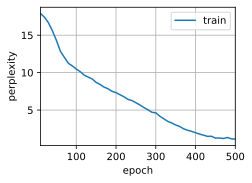

perplexity 1.1, 76609.4 tokens/sec on cuda:0
time traveller whing to begin uponaidd trace abe i me and se tor
travelleryou can show black is white by argument said filby


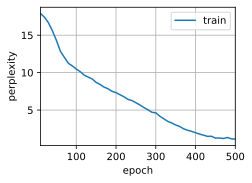

In [5]:
"""
让我们通过实例化 8.5节中 引入的RNNModelScratch类来训练一个长短期记忆网络， 就如我们在 9.1节中所做的一样。
"""
vocab_size,num_hiddens,device = len(vocab),256,d2l.try_gpu()

num_epochs,lr = 500,1

model = d2l.RNNModelScratch(vocab_size,num_hiddens,device,get_lstm_params,init_lstm_state,lstm)

d2l.train_ch8(model,train_iter,vocab,lr,num_epochs,device)

## 9.2.3. 简洁实现

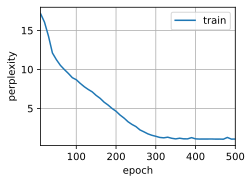

perplexity 1.1, 716592.2 tokens/sec on cuda:0
time travelleryou can show black is white by argument said filby
travelleryou can show black is white by argument said filby


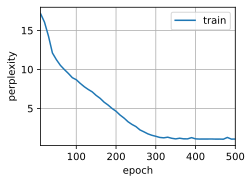

In [6]:
"""
使用高级API，我们可以直接实例化LSTM模型。 高级API封装了前文介绍的所有配置细节。 这段代码的运行速度要快得多， 因为它使用的是编译好的运算符而不是Python来处理之前阐述的许多细节。
"""
num_inputs = vocab_size
lstm_layer = nn.LSTM(num_inputs,num_hiddens)
model = d2l.RNNModel(lstm_layer,len(vocab))
model = model.to(device)
d2l.train_ch8(model,train_iter,vocab,lr,num_epochs,device)

长短期记忆网络是典型的具有重要状态控制的隐变量自回归模型。 多年来已经提出了其许多变体，例如，多层、残差连接、不同类型的正则化。 然而，由于序列的长距离依赖性，训练长短期记忆网络 和其他序列模型（例如门控循环单元）的成本是相当高的。 在后面的内容中，我们将讲述更高级的替代模型，如transformer。

## 9.2.4. 小结
- 长短期记忆网络有三种类型的门：输入门、遗忘门和输出门。
- 长短期记忆网络的隐藏层输出包括“隐状态”和“记忆元”。只有隐状态会传递到输出层，而记忆元完全属于内部信息。
- 长短期记忆网络可以缓解梯度消失和梯度爆炸。